In [90]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

num_nodes = 10
p = 0.1
G = nx.fast_gnp_random_graph(num_nodes, p, directed=True)
A = nx.adjacency_matrix(G)
B = nx.incidence_matrix(G, oriented=True).T

In [91]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("\nAdjacency matrix A:")
print(A.todense())
print("\nIncidence matrix B:")
print(B.todense())

Number of nodes: 10
Number of edges: 10

Adjacency matrix A:
[[0 0 1 1 0 0 1 0 0 0]
 [1 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 1]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]

Incidence matrix B:
[[-1.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 1. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  1.  0.]]


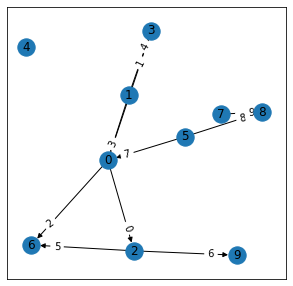

In [103]:
# Plot the graph and label the nodes.
# Note that the edge numbers correspond to the rows in B, and the 
# node numbers correspond to the columns (and both rows/columns
# of A)
node_pos = nx.spring_layout(G)
nx.draw_networkx(G, node_pos)
edge_labels = {e: i for i, e in enumerate(G.edges)}
nx.draw_networkx_edge_labels(G, node_pos, edge_labels=edge_labels, label_pos=0.25)
# plt.gca().set_aspect(1)
plt.gcf().set_size_inches(5, 5)
plt.show()

In [93]:
A

<10x10 sparse matrix of type '<class 'numpy.int64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [131]:
from sklearn.decomposition import non_negative_factorization

W, H, _ = non_negative_factorization(A, n_components=5)

/home/ecotner/neural_tsp/venv/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1035: FutureWarning: The default value of init will change from random to None in 0.23 to make it consistent with decomposition.NMF.
  "with decomposition.NMF.", FutureWarning)


In [132]:
np.round(W@H-A, 2)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [133]:
AA = H@W
AA

array([[0.00000000e+000, 1.68444211e-005, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 1.38535116e-010, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000],
       [3.38769973e-107, 1.97151250e+000, 1.42174624e-107,
        0.00000000e+000, 0.00000000e+000],
       [1.39829359e-004, 7.87581424e-010, 5.86834375e-005,
        0.00000000e+000, 0.00000000e+000],
       [7.45384456e+000, 4.19833827e-005, 3.12822159e+000,
        0.00000000e+000, 0.00000000e+000]])

In [134]:
G_emb = nx.from_numpy_array(AA)

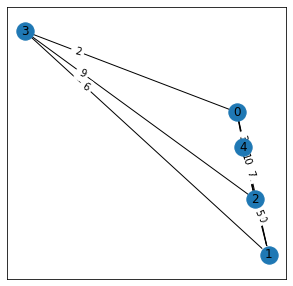

In [135]:
node_pos = nx.spring_layout(G_emb)
nx.draw_networkx(G_emb, node_pos)
edge_labels = {e: i for i, e in enumerate(G_emb.edges)}
nx.draw_networkx_edge_labels(G, node_pos, edge_labels=edge_labels, label_pos=0.25)
# plt.gca().set_aspect(1)
plt.gcf().set_size_inches(5, 5)
plt.show()

<hr style="height: 10px;"/>

## Gym environment

In [1]:
from typing import Tuple
from collections import namedtuple

import gym
from gym import spaces
import networkx as nx
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

State = namedtuple('State', 'locs, dist_matrix, order, dist')

class TSPEnvironment(gym.Env):
    def __init__(self, num_locs_range: Tuple[int, int]):
        super(TSPEnvironment, self).__init__()
        self.num_locs_range = num_locs_range
        self.reset()
        
    def step(self, action):
        # Update internal state and calculate reward
        self._update_state(action)
        # Get experience tuple
        state = self._next_observation()
        reward = self.reward
        done = False
        info = dict()
        return state, reward, done, info
    
    def reset(self):
        """Reset the environment.
        
        Creates a new set of locations chosen from a uniform distribution,
        calculates their distance matrix, etc.
        """
        # Create stop locations
        self.num_locs = np.random.randint(*self.num_locs_range)
        self.locations = np.random.uniform(low=0, high=1, size=(self.num_locs, 2)).astype(np.float32)
        # Calculate distance matrix between locations
        self.D = squareform(pdist(self.locations, metric='euclidean')).astype(np.float32)
        # Set initial visitiation order (in sequence by index by default)
        self.order = np.arange(self.num_locs)
        
        # Set up state space
        self.observation_space = spaces.Tuple((
            spaces.Box(low=0.0, high=1.0, shape=(self.num_locs, 2), dtype=np.float32), # (x,y) location of stops
            spaces.Box(low=0.0, high=self.D.max(), shape=self.D.shape, dtype=np.float32), # Distance matrix between locations
            spaces.Box(low=-np.inf, high=np.inf, shape=(self.num_locs,)), # The previous visitation order
            spaces.Box(low=0.0, high=self.D.max()*self.num_locs, shape=()), # The distance of the last iteration
        ))
        # Maybe include previous actions in state space?
        
        # Action space is vector of ranks (the order in which to visit nodes); could be any real number in principle
        self.action_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.num_locs,))
        
        # Initialize rewards
        self._update_state(self.order)
        
        return self._next_observation()
    
    def render(self):
        """Render a plot of the TSP circuit?"""
        fig, ax = plt.subplots()
        for i, loc in enumerate(self.locations):
            m = f"${i}$"
            ax.scatter(*loc, marker=m, s=100/len(str(i)), color='black')
        locs = self.locations[self.order]
        ax.plot(*locs.T)
        ax.plot(*locs[((-1,0),)].T, color='C0')
        plt.show()
    
    def close(self):
        pass
    
    def seed(self):
        pass
    
    def _next_observation(self):
        return State(self.locations, self.D, self.order, self.obj_value)
    
    def _update_state(self, action):
        # Get the visitation order by ranking the elements of <action>
        order = np.argsort(action)
        self.order = order
        # Get the total distance of the circuit
        idx = np.vstack([order, np.roll(order, -1)])
        dist = self.D[idx].sum()
        # Update reward/objective
        self.obj_value = dist
        self.reward = -dist
        return None
        

In [2]:
env = TSPEnvironment(num_locs_range=[5,10])

/home/ecotner/neural_tsp/venv/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [270]:
s = env.reset()

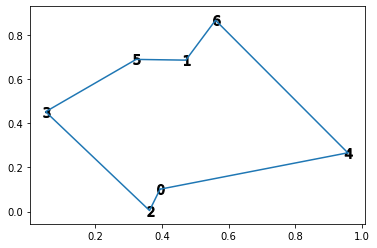

In [308]:
env.render()

In [307]:
s, _, _ , _ = env.step([-1,3,0,1,10,2,4])

In [302]:
print("locations:")
print(s.locs, end="\n\n")
print("distance matrix:")
print(s.dist_matrix, end="\n\n")
print("visitation order:")
print(s.order, end="\n\n")
print("previous distance:")
print(s.dist, end="\n")

locations:
[[0.39434946 0.10107391]
 [0.47155508 0.6853531 ]
 [0.3628143  0.00459075]
 [0.05118462 0.45187128]
 [0.9574772  0.2658798 ]
 [0.32256848 0.688668  ]
 [0.5606619  0.8659193 ]]

distance matrix:
[[0.         0.58935803 0.10150599 0.49073505 0.58674854 0.5919623
  0.78271854]
 [0.58935803 0.         0.68939245 0.4808587  0.64193314 0.14902349
  0.20135584]
 [0.10150599 0.68939245 0.         0.5451357  0.6495352  0.6852601
  0.8837593 ]
 [0.49073505 0.4808587  0.5451357  0.         0.92518055 0.36016926
  0.6565081 ]
 [0.58674854 0.64193314 0.6495352  0.92518055 0.         0.7627968
  0.7193815 ]
 [0.5919623  0.14902349 0.6852601  0.36016926 0.7627968  0.
  0.2968274 ]
 [0.78271854 0.20135584 0.8837593  0.6565081  0.7193815  0.2968274
  0.        ]]

visitation order:
[0 3 6 1 5 2 4]

previous distance:
47.160583


In [291]:
s.locs[((-1,0),)]

array([[0.06844644, 0.15778448],
       [0.8870637 , 0.8765944 ]], dtype=float32)

In [285]:
s.locs

array([[0.8870637 , 0.8765944 ],
       [0.33737645, 0.21738835],
       [0.00816211, 0.60282916],
       [0.15506022, 0.4497914 ],
       [0.37263674, 0.39765278],
       [0.33358738, 0.02661793],
       [0.06844644, 0.15778448]], dtype=float32)